In [ ]:
#imports
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import randrange
from math import sqrt


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#import data from local files
from google.colab import files
uploaded = files.upload()

Saving diabetes.csv to diabetes (1).csv


In [ ]:
#transform imports to dataframes
df = pd.read_csv(io.BytesIO(uploaded['diabetes.csv']))
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
# split data into train/test, 80/20 split
# with class imbalance stratified sampling is probably best here, but simple, non-randomized splitting is substituted for simplicity
# we will inspect the distribution of outcomes for both training and test to ensure this split is reasonable

split_number = round(len(df) * .8)
training, test = df[:split_number].copy(), df[split_number:].copy()

In [ ]:
training.describe() # 34.6% mean outcome
test.describe() # 35.7% mean outcome
# the class imbalance is represented similarly in the training and test splits, so we'll move forward with data preprocessing

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000
mean,4.019481,122.675325,71.428571,20.058442,77.805195,32.400000,0.434786,33.415584,0.357143
std,3.466876,28.904142,18.191378,15.971477,109.828213,7.521177,0.306497,11.746618,0.480721
min,0.000000,56.000000,0.000000,0.000000,0.000000,0.000000,0.115000,21.000000,0.000000
25%,1.000000,102.000000,62.000000,0.000000,0.000000,27.775000,0.224750,23.250000,0.000000
50%,3.000000,120.000000,74.000000,23.000000,0.000000,32.400000,0.337500,28.500000,0.000000
75%,6.000000,139.500000,81.500000,32.000000,130.000000,36.750000,0.563750,42.000000,1.000000
max,13.000000,199.000000,114.000000,49.000000,540.000000,57.300000,1.698000,70.000000,1.000000


In [ ]:
# missing value exploration
# https://towardsdatascience.com/easy-data-science-with-r-and-python-diabetes-among-the-pima-indians-an-exploratory-analysis-d7bc321d0fa7
print(training.shape[0])
training.astype(bool).sum(axis=0)

614


Pregnancies                 520
Glucose                     609
BloodPressure               584
SkinThickness               437
Insulin                     319
BMI                         605
DiabetesPedigreeFunction    614
Age                         614
Outcome                     213
dtype: int64

Pregnancies - 0 is a valid value
Glucose - 5 missing values, impute with mean/median - check distribution
BloodPressure - 30 missing values, impute with mean/median - check distribution
SkinThickness -  177 missing values
Insulin - 

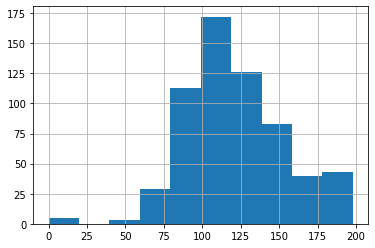

In [ ]:
# glucose transformation
training['Glucose'].hist()

#impute with median
gl_median = training['Glucose'].median()
gl_mask = training['Glucose'] == 0
training.loc[gl_mask, 'Glucose'] = gl_median

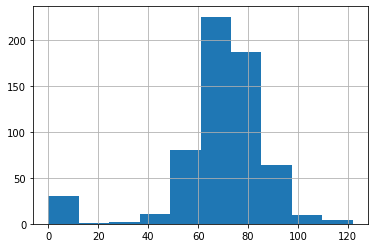

In [ ]:
training['BloodPressure'].hist()

# impute with median
bp_median = training['BloodPressure'].median()
bp_mask = training['BloodPressure'] == 0
training.loc[bp_mask, 'BloodPressure'] = bp_median

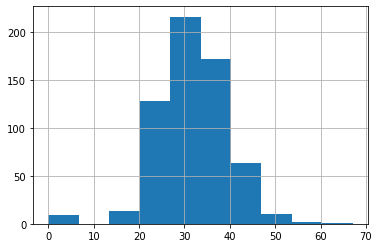

In [ ]:
training['BMI'].hist()
#impute with median

bmi_median = training['BMI'].median()
bmi_mask = training['BMI'] == 0
training.loc[bmi_mask, 'BMI'] = bmi_median

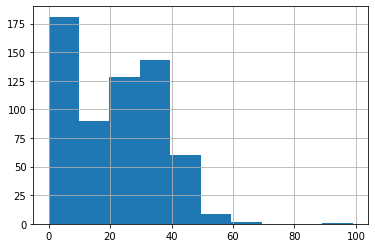

In [ ]:
training['SkinThickness'].hist()
 
st_array = training['SkinThickness'].to_numpy()
st_nonzero = st_array [np.nonzero(st_array)]

# remove zeroes, impute with median - 
# I considered using bmi to impute because of strong correlation, but will use the simple median for this exploration
st_median = np.median(st_nonzero)
mask = training['SkinThickness'] == 0
training.loc[mask, 'SkinThickness'] = st_median


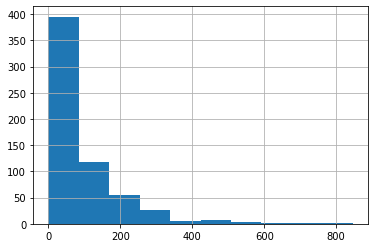

In [ ]:
training['Insulin'].hist()
# this is a mess, significant amount missing data. let's inspect to see how important it is

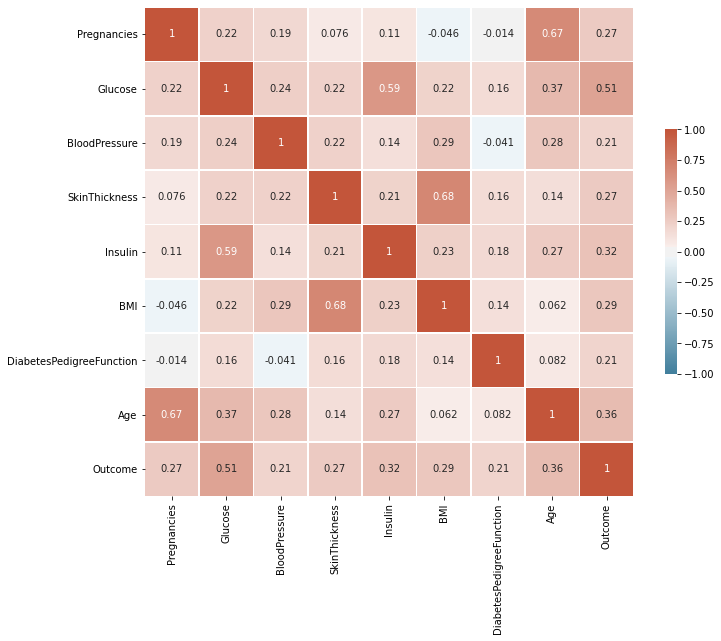

In [ ]:
#create subset of non-missing insulin data
in_subset = training.loc[training.Insulin != 0]
subset_corr = in_subset.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# # Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the correlation heatmap 
sns.heatmap(subset_corr, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

If insulin is present, it is moderately correlated to output. However, it is also correlated with glucose levels, which has an even stronger correlation with outcome. Because of this relationship, and the limited amount of data (~50% in training set) I will exclude insulin levels from this exploration. There's some interesting work with fuzzy imputation, but it outside the scope of this problem. 

In [ ]:
# drop insulin and inspect
training = training.drop(columns=['Insulin'])
training.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,3.801303,121.392508,71.942997,29.016287,32.359446,0.481179,33.197068,0.346906
std,3.346191,30.829807,11.961398,9.031018,6.960839,0.336866,11.772805,0.476373
min,0.000000,44.000000,24.000000,7.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,25.000000,27.400000,0.248000,24.000000,0.000000
50%,3.000000,116.000000,70.000000,29.000000,32.000000,0.386500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,32.000000,36.500000,0.647000,40.000000,1.000000
max,17.000000,198.000000,122.000000,99.000000,67.100000,2.420000,81.000000,1.000000


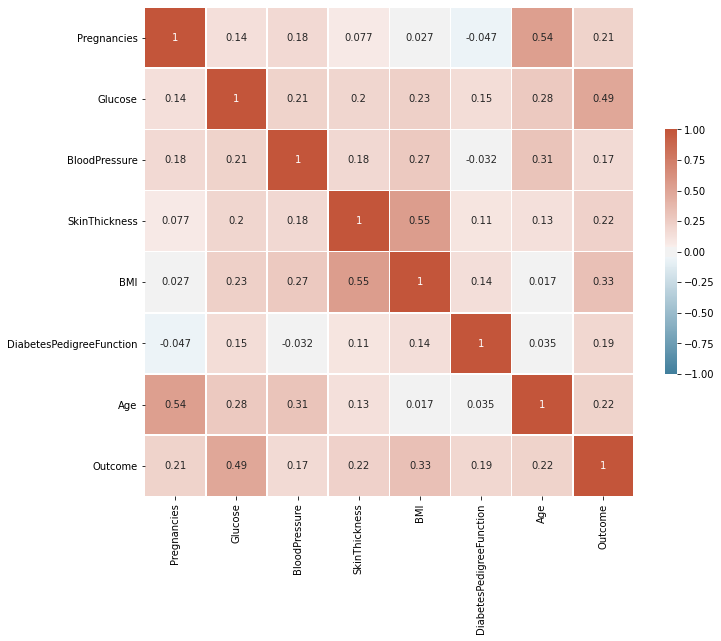

In [ ]:
corr = training.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# # Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the correlation heatmap 
sns.heatmap(corr, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

In [ ]:
def pima_data_transformation(data, gl_median, st_median, bp_median, bmi_median):

  # Glucose Transformation
  gl_mask = data['Glucose'] == 0
  data.loc[gl_mask, 'Glucose'] = gl_median

  # Skin Thickness Tranformation
  st_mask = data['SkinThickness'] == 0
  data.loc[st_mask, 'SkinThickness'] = st_median

  # Blood Pressure Transformation
  bp_mask = data['BloodPressure'] == 0
  data.loc[bp_mask, 'BloodPressure'] = bp_median
  
  # BMI Transformation
  bmi_mask = data['BMI'] == 0
  data.loc[bmi_mask, 'SkinThickness'] = bmi_median

  # Drop Insulin Column
  data = data.drop(columns=['Insulin'])

  return data